In [7]:
%load_ext autoreload
%autoreload 2

In [1]:
from modules import data_loader
from modules import metrics
from modules import gmp_model
from modules import learning
from modules import plotting
from modules import utils
import matplotlib.pyplot as plt
import numpy as np

from modules.gmp_narx_model import NarxGeneralizedMemoryPolynomial

import matlab.engine
eng = matlab.engine.start_matlab()


Load data from files

In [2]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
nperseg = float(config["nperseg"])

x_in_tensor = data["train_input"]
x_out_tensor = data["train_output"]
y_in_tensor = data["val_input"]
y_out_tensor = data["val_output"]


In [3]:
# задание целевого сигнала как k*In

gain = metrics.calculate_gain_complex(x_in_tensor, x_out_tensor)
print(f"Gain of PA= {gain:.2f}")

x_target = gain * x_in_tensor
y_target = gain * y_in_tensor


Gain of PA= 2.52


PA model

In [8]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=5

pa_model = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="pa_grad")

# проверка, существуют ли сохранённые коэффициенты для этого набора параметров, если нет, то они будут рассчитаны
if not pa_model.load_coefficients():
    pa_model.optimize_coefficients_grad(x_in_tensor, x_out_tensor, epochs=10000, learning_rate=0.01)
    pa_model.save_coefficients()
# else:
#     pa_model.optimize_coefficients_grad(x_in_tensor, x_out_tensor, epochs=10000, learning_rate=0.00001)
#     pa_model.save_coefficients()

y_gmp_pa = pa_model.compute_output(y_in_tensor).detach()

nmse_pa = metrics.compute_nmse(y_gmp_pa, y_out_tensor)
print(f"NMSE PA: {nmse_pa}")

Coefficients loaded from model_params/pa_grad_gmp_model_Ka5_La5_Kb6_Lb5_Mb6_Kc6_Lc5_Mc6.pt
NMSE PA: -30.188596725463867


In [23]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=Dy=3

pa_narx = NarxGeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, Dy, model_type="pa_grad_narx")

if not pa_narx.load_coefficients():
    pa_narx.optimize_coefficients_grad(x_in_tensor, x_out_tensor, epochs=10000, learning_rate=0.1)
    pa_narx.save_coefficients()
# else:
#     pa_model.optimize_coefficients_grad(x_in_tensor, x_out_tensor, epochs=10000, learning_rate=0.00001)
#     pa_model.save_coefficients()

y_gmp_pa_narx = pa_narx.compute_output(y_in_tensor).detach()

nmse_pa_narx = metrics.compute_nmse(y_gmp_pa_narx, y_out_tensor)
print(f"NMSE PA: {nmse_pa_narx}")

No saved coefficients found at model_params/pa_grad_narx_narx_gmp_model_Ka3_La3_Kb4_Lb3_Mb4_Kc4_Lc3_Mc4_Dy3.pt, initializing new parameters.
Epoch [1/10000], Loss: 1.2154501676559448
Epoch [2/10000], Loss: 1.391169786453247
Epoch [3/10000], Loss: 0.8329946994781494
Epoch [4/10000], Loss: 0.38385528326034546
Epoch [5/10000], Loss: 0.26453304290771484
Epoch [6/10000], Loss: 0.5378813743591309
Epoch [7/10000], Loss: 0.7553473711013794
Epoch [8/10000], Loss: 0.6193362474441528
Epoch [9/10000], Loss: 0.3605254292488098
Epoch [10/10000], Loss: 0.20581486821174622
Epoch [11/10000], Loss: 0.1664823740720749
Epoch [12/10000], Loss: 0.17609471082687378
Epoch [13/10000], Loss: 0.19134938716888428
Epoch [14/10000], Loss: 0.20010307431221008
Epoch [15/10000], Loss: 0.20848998427391052
Epoch [16/10000], Loss: 0.20795394480228424
Epoch [17/10000], Loss: 0.18223580718040466
Epoch [18/10000], Loss: 0.14291633665561676
Epoch [19/10000], Loss: 0.10958412289619446
Epoch [20/10000], Loss: 0.091562822461128

KeyboardInterrupt: 

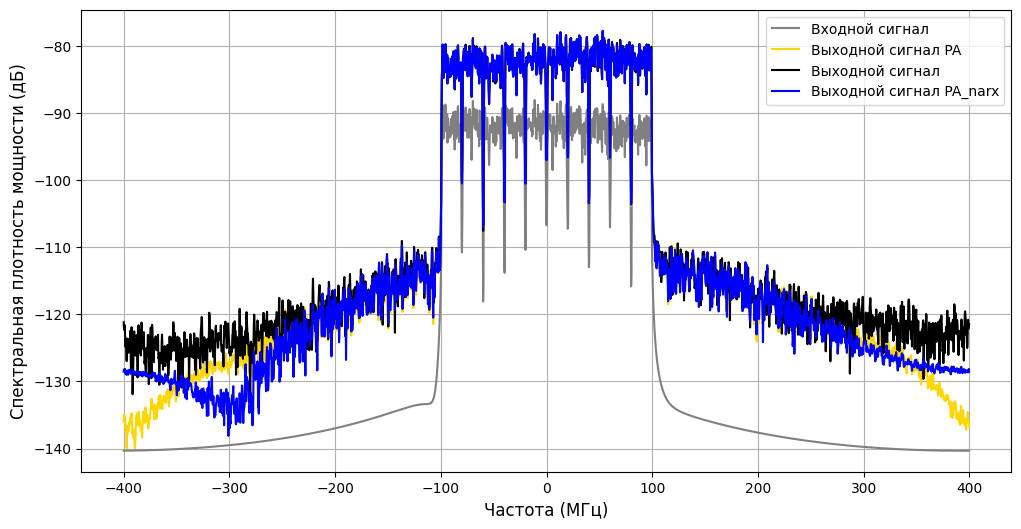

In [10]:
freqs, spectrum_y_in = metrics.power_spectrum(y_in_tensor, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_out_tensor, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_gmp_pa, fs, nperseg)
_, spectrum_y_gmp_pa_narx = metrics.power_spectrum(y_gmp_pa_narx, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa)), color='gold', label='Выходной сигнал PA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_out)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa_narx)), color='blue', label='Выходной сигнал PA_narx')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


DLA DPD grad

In [24]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=2

dpd_model_dla_grad = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla_grad")

if not dpd_model_dla_grad.load_coefficients():
    learning.optimize_dla_grad(x_in_tensor, x_target, dpd_model_dla_grad, pa_model, epochs=5000, learning_rate=0.01)
    dpd_model_dla_grad.save_coefficients()

# else:
#     learning.optimize_dla_grad(x_in_tensor, x_target, dpd_model_dla_grad, pa_model, epochs=1000, learning_rate=0.001)
#     dpd_model_dla_grad.save_coefficients()

y_dpd_dla_grad = dpd_model_dla_grad.compute_output(y_in_tensor).detach()
y_linearized_dla_grad = pa_model.compute_output(y_dpd_dla_grad).detach()

nmse_dla = metrics.compute_nmse(y_linearized_dla_grad, y_target)
print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla}")

Coefficients loaded from model_params/dpd_dla_grad_gmp_model_Ka2_La2_Kb3_Lb2_Mb3_Kc3_Lc2_Mc3.pt
NMSE на выходе усилителя (DLA DPD): -30.496322631835938


In [ ]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=Dy=3

dla_narx = NarxGeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, Dy, model_type="dpd_dla")

if not dla_narx.load_coefficients():
    learning.optimize_dla_grad(x_in_tensor, x_target, dla_narx, pa_model, narx=True, epochs=5000, learning_rate=0.01)
    dla_narx.save_coefficients()

# else:
#     learning.optimize_dla_grad(x_in_tensor, x_target, dpd_model_dla_grad, pa_model, epochs=1000, learning_rate=0.001)
#     dpd_model_dla_grad.save_coefficients()

y_dla_narx = dla_narx.compute_output(y_in_tensor).detach()
y_linearized_dla_narx = pa_model.compute_output(y_dla_narx).detach()

nmse_dla_narx = metrics.compute_nmse(y_linearized_dla_narx, y_target)
print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla_narx}")

No saved coefficients found at model_params/dpd_dla_grad_narx_narx_gmp_model_Ka2_La2_Kb3_Lb2_Mb3_Kc3_Lc2_Mc3_Dy2.pt, initializing new parameters.
Epoch [1/5000], Loss: 0.7504996657371521
Epoch [2/5000], Loss: 0.4153582751750946
Epoch [3/5000], Loss: 0.13882581889629364
Epoch [4/5000], Loss: 0.09610971063375473
Epoch [5/5000], Loss: 0.1468370258808136
Epoch [6/5000], Loss: 0.19349028170108795
Epoch [7/5000], Loss: 0.2201247364282608
Epoch [8/5000], Loss: 0.21994361281394958
Epoch [9/5000], Loss: 0.1956782191991806
Epoch [10/5000], Loss: 0.15470239520072937
Epoch [11/5000], Loss: 0.10510384291410446
Epoch [12/5000], Loss: 0.05918266996741295
Epoch [13/5000], Loss: 0.031430233269929886
Epoch [14/5000], Loss: 0.029094483703374863
Epoch [15/5000], Loss: 0.04462096467614174
Epoch [16/5000], Loss: 0.062088072299957275
Epoch [17/5000], Loss: 0.07079797238111496
Epoch [18/5000], Loss: 0.06951901316642761
Epoch [19/5000], Loss: 0.06146654114127159
Epoch [20/5000], Loss: 0.048930950462818146
Epoc

ILA DPD grad

In [18]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=3

dpd_model_ila_grad = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila_grad")

if not dpd_model_ila_grad.load_coefficients():
    learning.optimize_ila_grad(dpd_model_ila_grad, x_in_tensor, x_out_tensor, gain, epochs=5000, learning_rate=0.01)
    dpd_model_ila_grad.save_coefficients()

y_dpd_ila_grad = dpd_model_ila_grad.compute_output(y_in_tensor).detach()
y_linearized_ila_grad = pa_model.compute_output(y_dpd_ila_grad).detach()

nmse_ila = metrics.compute_nmse(y_linearized_ila_grad, y_target)
print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila}")


Coefficients loaded from model_params/dpd_ila_grad_gmp_model_Ka3_La3_Kb4_Lb3_Mb4_Kc4_Lc3_Mc4.pt
NMSE на выходе усилителя (ILA DPD): -34.270774841308594


ILC DPD grad

In [13]:
u_k = learning.ilc_signal_grad(x_in_tensor, x_target, pa_model, max_iterations=1000, learning_rate=0.001)

u_k_pa = pa_model.compute_output(u_k).detach()

Iteration 1/1000, Loss: 0.06106162071228027
Iteration 2/1000, Loss: 0.059235576540231705
Iteration 3/1000, Loss: 0.057456545531749725
Iteration 4/1000, Loss: 0.055723778903484344
Iteration 5/1000, Loss: 0.05403628200292587
Iteration 6/1000, Loss: 0.05239308625459671
Iteration 7/1000, Loss: 0.05079330876469612
Iteration 8/1000, Loss: 0.04923605918884277
Iteration 9/1000, Loss: 0.047720495611429214
Iteration 10/1000, Loss: 0.046245772391557693
Iteration 11/1000, Loss: 0.04481108859181404
Iteration 12/1000, Loss: 0.04341566935181618
Iteration 13/1000, Loss: 0.04205872118473053
Iteration 14/1000, Loss: 0.04073946177959442
Iteration 15/1000, Loss: 0.03945712745189667
Iteration 16/1000, Loss: 0.03821096941828728
Iteration 17/1000, Loss: 0.03700024634599686
Iteration 18/1000, Loss: 0.03582422807812691
Iteration 19/1000, Loss: 0.034682177007198334
Iteration 20/1000, Loss: 0.03357335925102234
Iteration 21/1000, Loss: 0.03249705210328102
Iteration 22/1000, Loss: 0.031452521681785583
Iteration 23

In [19]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=3

dpd_model_ilc_grad = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc_grad")

if not dpd_model_ilc_grad.load_coefficients():
    dpd_model_ilc_grad.optimize_coefficients_grad(x_in_tensor, u_k, epochs=5000, learning_rate=0.01)
    dpd_model_ilc_grad.save_coefficients()

y_dpd_ilc_grad = dpd_model_ilc_grad.compute_output(y_in_tensor).detach()
y_linearized_ilc_grad = pa_model.compute_output(y_dpd_ilc_grad).detach()

nmse_ilc = metrics.compute_nmse(y_linearized_ilc_grad, y_target)
print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc}")

Coefficients loaded from model_params/dpd_ilc_grad_gmp_model_Ka3_La3_Kb4_Lb3_Mb4_Kc4_Lc3_Mc4.pt
NMSE на выходе усилителя (ILC DPD): -35.03954315185547


Metrics

In [15]:
nmse_after_pa = metrics.compute_nmse(y_gmp_pa, y_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")

print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla:.2f} db")

print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila:.2f} db")

print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc:.2f} db")

NMSE на выходе усилителя (без DPD): -11.11 db
NMSE на выходе усилителя (DLA DPD): -35.07 db
NMSE на выходе усилителя (ILA DPD): -34.27 db
NMSE на выходе усилителя (ILC DPD): -35.04 db


In [16]:

y_in_acpr = metrics.calculate_acpr(eng, y_in_tensor, fs, bw_main_ch, nperseg)
y_out_acpr = metrics.calculate_acpr(eng, y_out_tensor, fs, bw_main_ch, nperseg)
y_gmp_pa_acpr = metrics.calculate_acpr(eng, y_gmp_pa, fs, bw_main_ch, nperseg)
y_target_acpr = metrics.calculate_acpr(eng, y_target, fs, bw_main_ch, nperseg)

y_linearized_dla_grad_acpr = metrics.calculate_acpr(eng, y_linearized_dla_grad, fs, bw_main_ch, nperseg)
y_linearized_ila_grad_acpr = metrics.calculate_acpr(eng, y_linearized_ila_grad, fs, bw_main_ch, nperseg)
y_linearized_ilc_grad_acpr = metrics.calculate_acpr(eng, y_linearized_ilc_grad, fs, bw_main_ch, nperseg)

print(f"y_in_acpr: {y_in_acpr}")
print(f"y_out_acpr: {y_out_acpr}")
print(f"y_gmp_pa_acpr: {y_gmp_pa_acpr}")
print(f"y_target_acpr: {y_target_acpr}")

print(f"linearized_dla_grad_acpr: {y_linearized_dla_grad_acpr}")
print(f"linearized_ila_grad_acpr: {y_linearized_ila_grad_acpr}")
print(f"linearized_ilc_grad_acpr: {y_linearized_ilc_grad_acpr}")


y_in_acpr: (-48.08516971297125, -48.40066679891268)
y_out_acpr: (-40.61545131352772, -38.202473200122654)
y_gmp_pa_acpr: (-43.56728813417723, -40.64633645271054)
y_target_acpr: (-48.08516917255388, -48.400666320235516)
linearized_dla_grad_acpr: (-47.904775273177734, -43.73324275313423)
linearized_ila_grad_acpr: (-47.3283731005162, -42.772028584648496)
linearized_ilc_grad_acpr: (-47.50640857790241, -43.1365994781363)


In [17]:
nmse_uk_pa = metrics.compute_nmse(u_k_pa, x_target)
print(f"NMSE на выходе усилителя (ILC): {nmse_uk_pa:.2f} db")

u_k_acpr = metrics.calculate_acpr(eng, u_k, fs, bw_main_ch, nperseg)
u_k_pa_acpr = metrics.calculate_acpr(eng, u_k_pa, fs, bw_main_ch, nperseg)

print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NMSE на выходе усилителя (ILC): -67.90 db
u_k_acpr: (-44.52634665956961, -49.30381626594817)
u_k_pa_acpr: (-50.88172393146402, -50.363996982187025)


Spectrum

In [21]:
freqs, spectrum_y_in = metrics.power_spectrum(y_in_tensor, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_out_tensor, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_gmp_pa, fs, nperseg)
_, spectrum_y_target = metrics.power_spectrum(y_target, fs, nperseg)

# _, spectrum_y_dpd_dla_grad = metrics.power_spectrum(y_dpd_dla_grad, fs, nperseg)
# _, spectrum_y_dpd_ila_grad = metrics.power_spectrum(y_dpd_ila_grad, fs, nperseg)
# _, spectrum_y_dpd_ilc_grad = metrics.power_spectrum(y_dpd_ilc_grad, fs, nperseg)

_, spectrum_y_linearized_dla_grad = metrics.power_spectrum(y_linearized_dla_grad, fs, nperseg)
_, spectrum_y_linearized_ila_grad = metrics.power_spectrum(y_linearized_ila_grad, fs, nperseg)
_, spectrum_y_linearized_ilc_grad = metrics.power_spectrum(y_linearized_ilc_grad, fs, nperseg)
_, spectrum_y_linearized_dla_narx = metrics.power_spectrum(y_linearized_dla_narx, fs, nperseg)

# _, spectrum_u_k = metrics.power_spectrum(u_k, fs, nperseg)
# _, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)

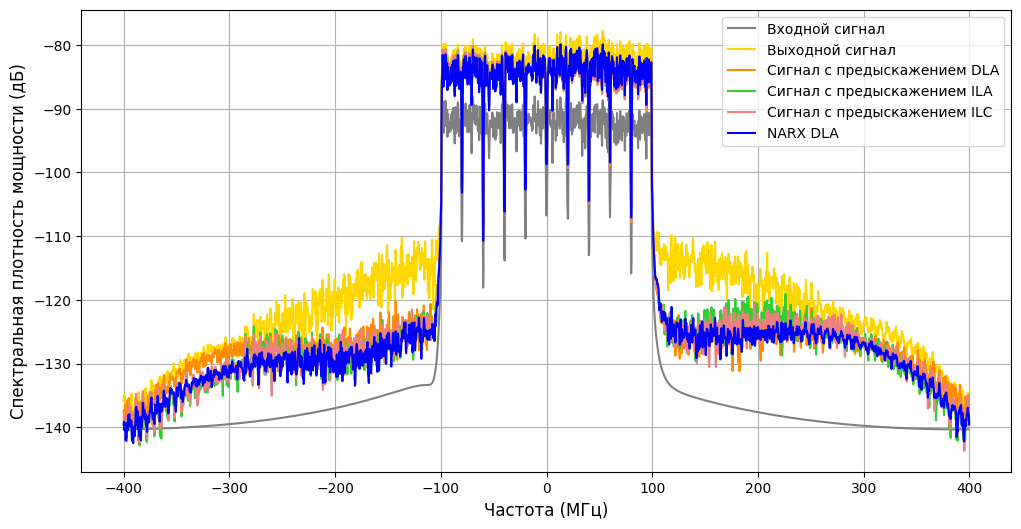

In [22]:
# построение спектра

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa)), color='gold', label='Выходной сигнал')
# plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa)), color='red', label='Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_dla_grad)), color='darkorange', label='Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ila_grad)), color='limegreen', label='Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ilc_grad)), color='lightcoral', label='Сигнал с предыскажением ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_dla_narx)), color='blue', label='NARX DLA')

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()



In [20]:
# moving_average
window_size = 60

freqs_s, spectrum_y_in_s = utils.moving_average(spectrum_y_in, freqs, fs, window_size)
_, spectrum_y_out_s = utils.moving_average(spectrum_y_out, freqs, fs, window_size)
_, spectrum_y_gmp_pa_s = utils.moving_average(spectrum_y_gmp_pa, freqs, fs, window_size)
_, spectrum_y_target_s = utils.moving_average(spectrum_y_target, freqs, fs, window_size)

# _, spectrum_y_dpd_dla_grad_s = utils.moving_average(spectrum_y_dpd_dla_grad, freqs, fs, window_size)
# _, spectrum_y_dpd_ila_grad_s = utils.moving_average(spectrum_y_dpd_ila_grad, freqs, fs, window_size)
# _, spectrum_y_dpd_ilc_grad_s = utils.moving_average(spectrum_y_dpd_ilc_grad, freqs, fs, window_size)

_, spectrum_y_linearized_dla_grad_s = utils.moving_average(spectrum_y_linearized_dla_grad, freqs, fs, window_size)
_, spectrum_y_linearized_ila_grad_s = utils.moving_average(spectrum_y_linearized_ila_grad, freqs, fs, window_size)
_, spectrum_y_linearized_ilc_grad_s = utils.moving_average(spectrum_y_linearized_ilc_grad, freqs, fs, window_size)

_, spectrum_u_k_s = utils.moving_average(spectrum_u_k, freqs, fs, window_size)
_, spectrum_u_k_pa_s = utils.moving_average(spectrum_u_k_pa, freqs, fs, window_size)



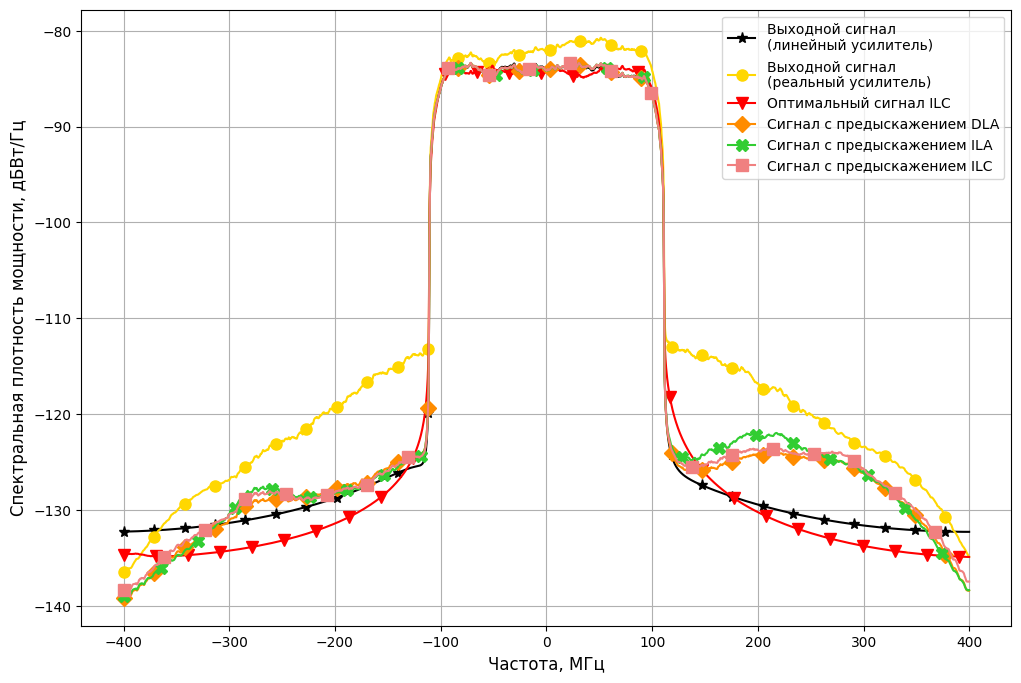

In [33]:
# (сглаженный) построение спектра

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_gmp_pa_s)), 
         color='gold', label='Выходной сигнал\n(реальный усилитель)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa_s)), 
         color='red', label='Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_dla_grad_s)), 
         color='darkorange', label='Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ila_grad_s)), 
         color='limegreen', label='Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_linearized_ilc_grad_s)), 
         color='lightcoral', label='Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


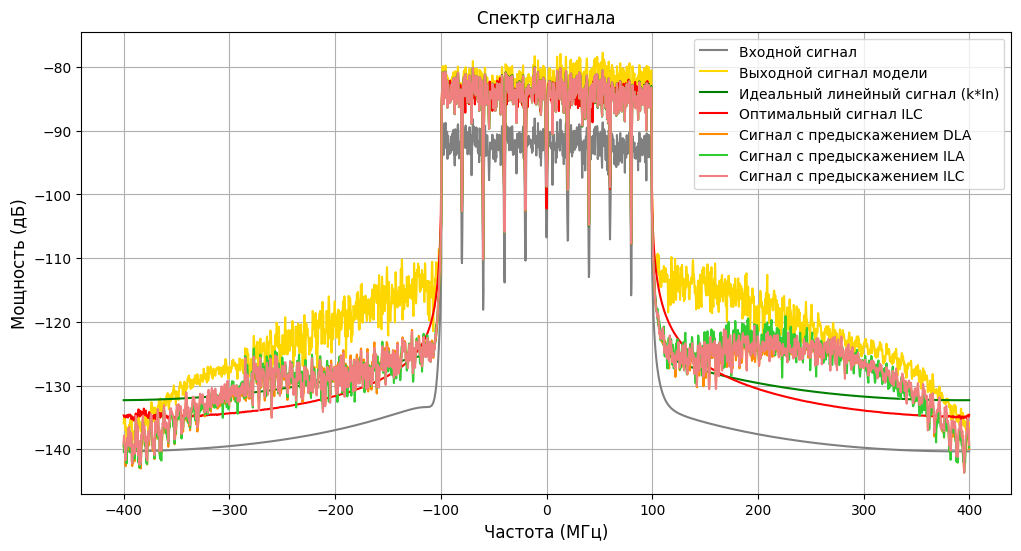

In [22]:
spectra = [
    (spectrum_y_in, 'grey', 'Входной сигнал'),
    # (spectrum_y_out, 'k', 'Выходной сигнал'),
    (spectrum_y_gmp_pa, 'gold', 'Выходной сигнал модели'),
    (spectrum_y_target, 'green', 'Идеальный линейный сигнал (k*In)'),
    # (spectrum_u_k, 'magenta', 'u_k'),
    (spectrum_u_k_pa, 'red', 'Оптимальный сигнал ILC'),
    (spectrum_y_linearized_dla_grad, 'darkorange', 'Сигнал с предыскажением DLA'),
    (spectrum_y_linearized_ila_grad, 'limegreen', 'Сигнал с предыскажением ILA'),
    (spectrum_y_linearized_ilc_grad, 'lightcoral', 'Сигнал с предыскажением ILC')
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)

AM/AM & AM/PM

In [49]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(y_in_tensor, y_out_tensor)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_out_tensor)

_, y_pa_am_am = metrics.calculate_am_am(y_in_tensor, y_gmp_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_gmp_pa)

_, y_target_am_am = metrics.calculate_am_am(y_in_tensor, y_target)
_, y_target_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_in_tensor, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_in_tensor, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k_pa)

# dpd
_, y_dpd_dla_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_dla_grad)
_, y_dpd_dla_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_dla_grad)

_, y_dpd_ila_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_ila_grad)
_, y_dpd_ila_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_ila_grad)

_, y_dpd_ilc_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_ilc_grad)
_, y_dpd_ilc_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_ilc_grad)

#linearized
_, y_linearized_dla_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_dla_grad)
_, y_linearized_dla_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_dla_grad)

_, y_linearized_ila_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_ila_grad)
_, y_linearized_ila_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_ila_grad)

_, y_linearized_ilc_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_ilc_grad)
_, y_linearized_ilc_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_ilc_grad)


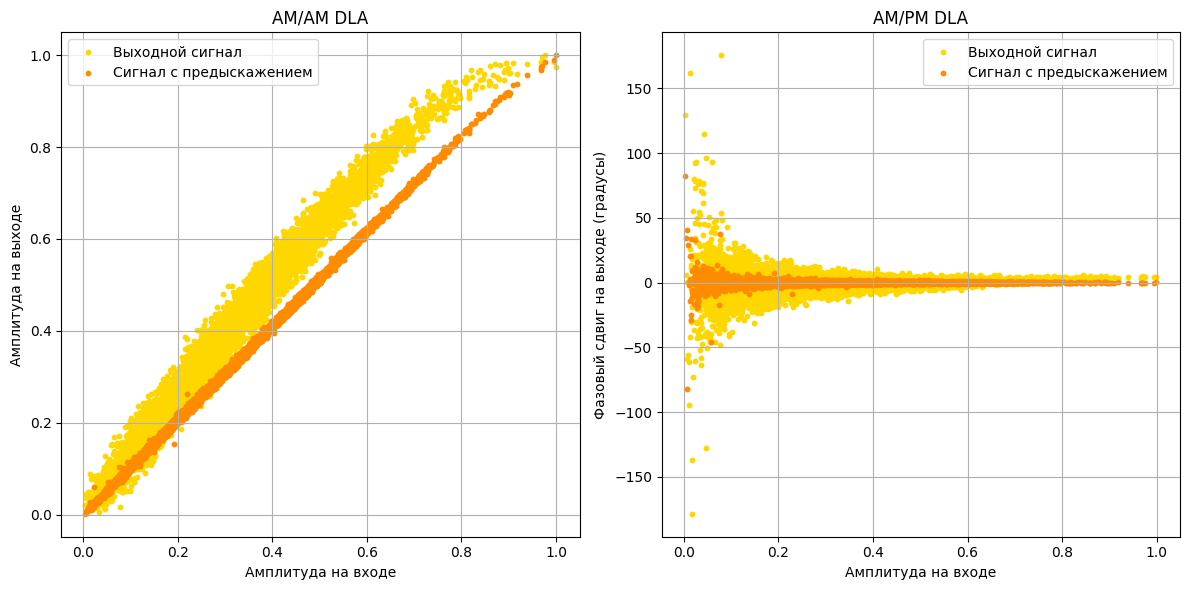

In [50]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_dla_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_dla_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_dla_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



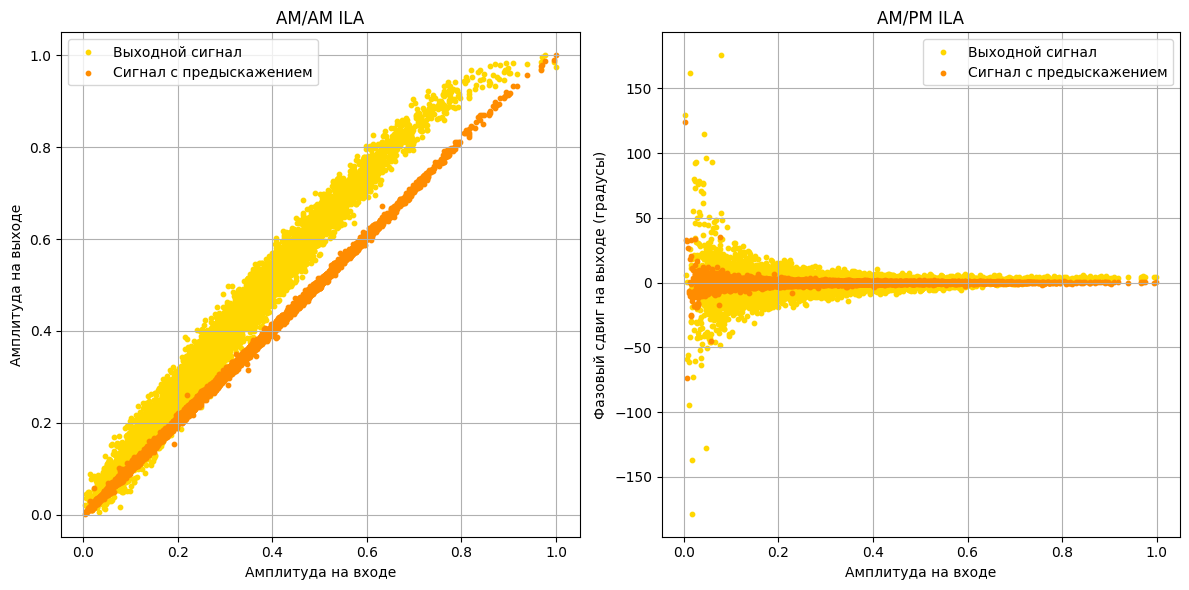

In [51]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ila_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_ila_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ila_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


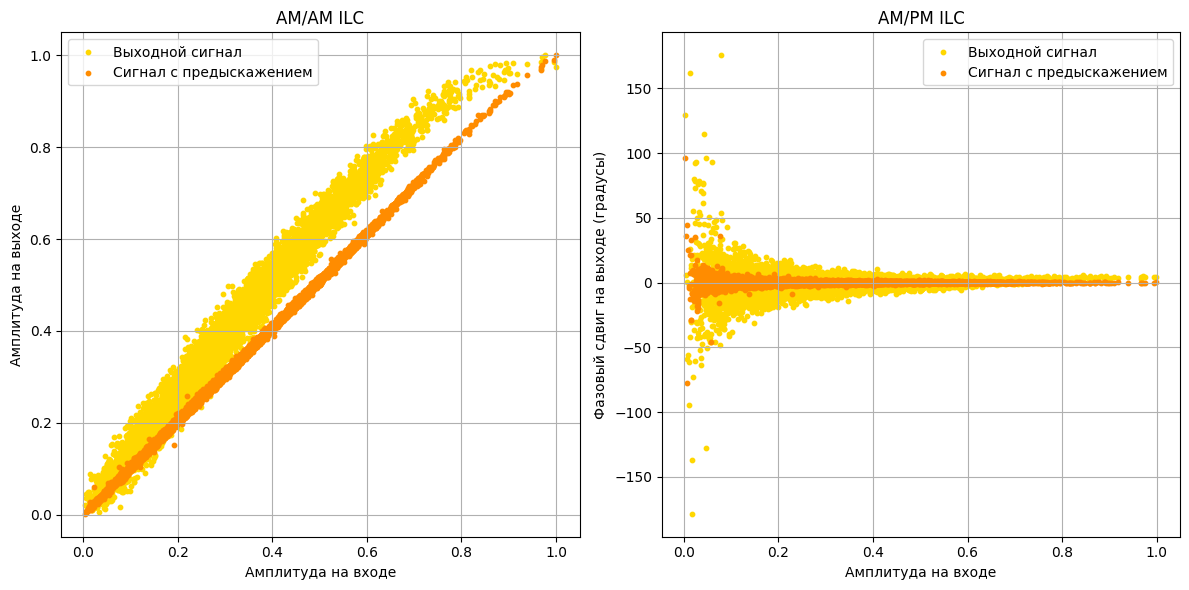

In [52]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ilc_grad_am_am, 'magenta', 'Сигнал на выходе корректора'),
    (y_in_am_am, y_linearized_ilc_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ilc_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


Add noise

In [23]:
snr_range = list(range(20, 61, 2))

Ka = La = Kb = Lb = Mb = Kc = Lc = Mc = 3
epochs = 500
lr = 0.01
num_realizations = 10

In [ ]:
nmse_dla_list = []
acpr_left_dla_list = []
acpr_right_dla_list = []

for snr in snr_range:
    print(f"Current SNR: {snr}")

    # DLA
    dpd_dla = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla")
    learning.optimize_dla_grad(x_in_tensor, x_target, dpd_dla, pa_model, epochs, lr, True, snr, fs, bw_main_ch)
    y_dla_pa = pa_model.compute_output(dpd_dla.compute_output(y_in_tensor)).detach()

    nmse_dla, acpr_left_dla, acpr_right_dla = metrics.noise_realizations(num_realizations, eng, y_dla_pa, y_target, snr, fs, bw_main_ch, nperseg)
    nmse_dla_list.append(nmse_dla)
    acpr_left_dla_list.append(acpr_left_dla)
    acpr_right_dla_list.append(acpr_right_dla)


Current SNR: 20
Epoch [1/500], Loss: 0.7592251896858215
Epoch [2/500], Loss: 0.4595874845981598
Epoch [3/500], Loss: 0.20374681055545807
Epoch [4/500], Loss: 0.33480826020240784
Epoch [5/500], Loss: 0.4394076466560364
Epoch [6/500], Loss: 0.2909787595272064
Epoch [7/500], Loss: 0.14757993817329407
Epoch [8/500], Loss: 0.06859137117862701
Epoch [9/500], Loss: 0.07800476253032684
Epoch [10/500], Loss: 0.12886548042297363
Epoch [11/500], Loss: 0.15388590097427368
Epoch [12/500], Loss: 0.13708536326885223
Epoch [13/500], Loss: 0.10454341024160385
Epoch [14/500], Loss: 0.08196345716714859
Epoch [15/500], Loss: 0.07365068793296814
Epoch [16/500], Loss: 0.0709800198674202
Epoch [17/500], Loss: 0.07150136679410934
Epoch [18/500], Loss: 0.07579395174980164
Epoch [19/500], Loss: 0.0868600457906723
Epoch [20/500], Loss: 0.0928940698504448
Epoch [21/500], Loss: 0.08789139240980148
Epoch [22/500], Loss: 0.07303638756275177
Epoch [23/500], Loss: 0.0533897839486599
Epoch [24/500], Loss: 0.04400087893

In [ ]:
nmse_ila_list = []
acpr_left_ila_list = []
acpr_right_ila_list = []

for snr in snr_range:
    print(f"Current SNR: {snr}")

    nmse_values, acpr_left_values, acpr_right_values = [], [], []
    for _ in range(num_realizations):
        dpd_ila = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila")
        learning.optimize_ila_grad(dpd_ila, x_in_tensor, x_target, gain, epochs, lr, pa_model, True, snr, fs, bw_main_ch)
        y_ila_pa = pa_model.compute_output(dpd_ila.compute_output(y_in_tensor)).detach()

        y_noise = metrics.add_complex_noise(y_ila_pa, snr, fs, bw_main_ch)
        nmse_values.append(metrics.compute_nmse(y_noise, y_target))
        acpr_left, acpr_right = metrics.calculate_acpr(eng, y_noise, fs, bw_main_ch, nperseg)
        acpr_left_values.append(acpr_left)
        acpr_right_values.append(acpr_right)
    
    nmse_ila_list.append(sum(nmse_values)/num_realizations)
    acpr_left_ila_list.append(sum(acpr_left_values)/num_realizations)
    acpr_right_ila_list.append(sum(acpr_right_values)/num_realizations)


Current SNR: 20
Compute on pa_model
Epoch [1/500], Loss: 0.1196875125169754
Epoch [2/500], Loss: 0.04456165060400963
Epoch [3/500], Loss: 0.05062675476074219
Epoch [4/500], Loss: 0.06048906221985817
Epoch [5/500], Loss: 0.04587510973215103
Epoch [6/500], Loss: 0.02750934474170208
Epoch [7/500], Loss: 0.014231710694730282
Epoch [8/500], Loss: 0.012269838713109493
Epoch [9/500], Loss: 0.021289415657520294
Epoch [10/500], Loss: 0.028070200234651566
Epoch [11/500], Loss: 0.024837711825966835
Epoch [12/500], Loss: 0.016400013118982315
Epoch [13/500], Loss: 0.010150866582989693
Epoch [14/500], Loss: 0.008910750970244408
Epoch [15/500], Loss: 0.011376097798347473
Epoch [16/500], Loss: 0.014842823147773743
Epoch [17/500], Loss: 0.016318487003445625
Epoch [18/500], Loss: 0.014105712063610554
Epoch [19/500], Loss: 0.009896685369312763
Epoch [20/500], Loss: 0.007217573933303356
Epoch [21/500], Loss: 0.007432885933667421
Epoch [22/500], Loss: 0.008786170743405819
Epoch [23/500], Loss: 0.0091544240

In [ ]:
nmse_uk_list = []
acpr_left_uk_list = []
acpr_right_uk_list = []

nmse_ilc_list = []
acpr_left_ilc_list = []
acpr_right_ilc_list = []

for snr in snr_range:
    print(f"Current SNR: {snr}")
    # ILC + UK
    dpd_ilc = gmp_model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc")
    uk = learning.ilc_signal_grad(x_in_tensor, x_target, pa_model, 500, 0.001, True, snr, fs, bw_main_ch)
    
    uk_pa = pa_model.compute_output(uk).detach()
    nmse_uk, acpr_left_uk, acpr_right_uk = metrics.noise_realizations(num_realizations, eng, uk_pa, x_target, snr, fs, bw_main_ch, nperseg)
    nmse_uk_list.append(nmse_uk)
    acpr_left_uk_list.append(acpr_left_uk)
    acpr_right_uk_list.append(acpr_right_uk)

    dpd_ilc.optimize_coefficients_grad(x_in_tensor, uk, epochs, lr)
    y_ilc_pa = pa_model.compute_output(dpd_ilc.compute_output(y_in_tensor)).detach()
    
    nmse_ilc, acpr_left_ilc, acpr_right_ilc = metrics.noise_realizations(num_realizations, eng, y_ilc_pa, y_target, snr, fs, bw_main_ch, nperseg)
    nmse_ilc_list.append(nmse_ilc)
    acpr_left_ilc_list.append(acpr_left_ilc)
    acpr_right_ilc_list.append(acpr_right_ilc)

Current SNR: 20
Iteration 1/500, Loss: 0.10779836773872375
Iteration 2/500, Loss: 0.10865171998739243
Iteration 3/500, Loss: 0.10616179555654526
Iteration 4/500, Loss: 0.10509596765041351
Iteration 5/500, Loss: 0.10360472649335861
Iteration 6/500, Loss: 0.10225029289722443
Iteration 7/500, Loss: 0.09919967502355576
Iteration 8/500, Loss: 0.09955509006977081
Iteration 9/500, Loss: 0.09846743196249008
Iteration 10/500, Loss: 0.096478670835495
Iteration 11/500, Loss: 0.09515917301177979
Iteration 12/500, Loss: 0.09354323148727417
Iteration 13/500, Loss: 0.09335006028413773
Iteration 14/500, Loss: 0.09128688275814056
Iteration 15/500, Loss: 0.08954286575317383
Iteration 16/500, Loss: 0.08890431374311447
Iteration 17/500, Loss: 0.0873304158449173
Iteration 18/500, Loss: 0.08648551255464554
Iteration 19/500, Loss: 0.08517985790967941
Iteration 20/500, Loss: 0.08485699445009232
Iteration 21/500, Loss: 0.08330199867486954
Iteration 22/500, Loss: 0.08137619495391846
Iteration 23/500, Loss: 0.08

In [62]:
def tensors_to_float(tensor_list):
    float_list = [t.item() for t in tensor_list]
    return float_list

nmse_dla_list = tensors_to_float(nmse_dla_list)
nmse_ila_list = tensors_to_float(nmse_ila_list)
nmse_ilc_list = tensors_to_float(nmse_ilc_list)
nmse_uk_list = tensors_to_float(nmse_uk_list)

In [64]:
print(f"snr_range = {snr_range}")
print()

print(f"nmse_dla_list = {(nmse_dla_list)}")
print(f"acpr_left_dla_list = {acpr_left_dla_list}")
print(f"acpr_right_dla_list = {acpr_right_dla_list}")
print()

print(f"nmse_ila_list = {nmse_ila_list}")
print(f"acpr_left_ila_list = {acpr_left_ila_list}")
print(f"acpr_right_ila_list = {acpr_right_ila_list}")
print()

print(f"nmse_ilc_list = {nmse_ilc_list}")
print(f"acpr_left_ilc_list = {acpr_left_ilc_list}")
print(f"acpr_right_ilc_list = {acpr_right_ilc_list}")
print()

print(f"nmse_uk_list = {nmse_uk_list}")
print(f"acpr_left_uk_list = {acpr_left_uk_list}")
print(f"acpr_right_uk_list = {acpr_right_uk_list}")

snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

nmse_dla_list = [-14.1044340133667, -16.018064498901367, -17.97743797302246, -19.84555435180664, -21.76476287841797, -23.601543426513672, -25.397140502929688, -27.051654815673828, -28.60270118713379, -29.951904296875, -31.10137939453125, -31.99922752380371, -32.693359375, -33.20136260986328, -33.556922912597656, -33.7752571105957, -33.94951248168945, -34.041229248046875, -34.11683654785156, -34.161094665527344, -34.18443298339844]
acpr_left_dla_list = [-19.98307782854365, -22.044059761313314, -24.047040241882005, -25.981348959580895, -27.975370600038946, -29.942117343851447, -31.96514345661867, -33.80510011678665, -35.72137883607495, -37.63892721922215, -39.546686668811134, -41.14783435664147, -42.72300193647455, -44.1586403570728, -45.36636102368466, -46.3075550113637, -47.042928773938236, -47.62786795374185, -48.053632118082476, -48.26038054693791, -48.41887604347718]
acpr_right_dla_list

In [24]:
# значения в виде списков чтобы не рассчитывать снова все значения

snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

nmse_dla_list = [-14.1044340133667, -16.018064498901367, -17.97743797302246, -19.84555435180664, -21.76476287841797, -23.601543426513672, -25.397140502929688, -27.051654815673828, -28.60270118713379, -29.951904296875, -31.10137939453125, -31.99922752380371, -32.693359375, -33.20136260986328, -33.556922912597656, -33.7752571105957, -33.94951248168945, -34.041229248046875, -34.11683654785156, -34.161094665527344, -34.18443298339844]
acpr_left_dla_list = [-19.98307782854365, -22.044059761313314, -24.047040241882005, -25.981348959580895, -27.975370600038946, -29.942117343851447, -31.96514345661867, -33.80510011678665, -35.72137883607495, -37.63892721922215, -39.546686668811134, -41.14783435664147, -42.72300193647455, -44.1586403570728, -45.36636102368466, -46.3075550113637, -47.042928773938236, -47.62786795374185, -48.053632118082476, -48.26038054693791, -48.41887604347718]
acpr_right_dla_list = [-20.041831052899113, -21.95478038014439, -23.98363774561688, -25.910596158467115, -27.91143197214374, -29.830851608311, -31.79363647332617, -33.5694401253062, -35.43604753655994, -37.07000947388168, -38.589720264578695, -39.981493718118756, -41.18240060456666, -42.0034433292463, -42.727465426518414, -43.28342016300996, -43.61496527628741, -43.81084719101566, -43.98201861121989, -44.08200476372817, -44.162913038570224]

nmse_ila_list = [-13.854040145874023, -15.777467727661133, -17.762771606445312, -19.657350540161133, -21.58496856689453, -23.4307918548584, -25.17462730407715, -26.818567276000977, -28.340505599975586, -29.61135482788086, -30.697265625, -31.556087493896484, -32.22067642211914, -32.64470291137695, -32.968238830566406, -33.183040618896484, -33.31875991821289, -33.422943115234375, -33.47233963012695, -33.510684967041016, -33.5294189453125]
acpr_left_ila_list = [-20.027768364406164, -22.02595135920506, -23.98453820660988, -25.961216816485567, -27.89464166886246, -29.93190200512903, -31.88604293318803, -33.82673998661604, -35.772038392214476, -37.61613725169961, -39.35554674161212, -40.999545012141596, -42.574679365583734, -43.93042452256015, -45.03867510014294, -45.908987401819914, -46.56702971768967, -47.03977254628908, -47.41264367177677, -47.67963051393086, -47.772995960135724]
acpr_right_ila_list = [-19.930579122305584, -21.869039603483063, -23.92589430272745, -25.8934186825347, -27.89435768624694, -29.824054115245037, -31.657192539039386, -33.574507705349546, -35.29508665583067, -36.91289391444029, -38.35332621280914, -39.531460585547265, -40.53575407057057, -41.37233528658536, -41.93340984815785, -42.33601701225255, -42.63072372715388, -42.78626262772036, -42.906565042070014, -42.98986099019487, -43.06106380151427]

nmse_ilc_list = [-14.0765962600708, -16.038497924804688, -17.95038604736328, -19.846113204956055, -21.75259017944336, -23.631811141967773, -25.368045806884766, -27.051647186279297, -28.601642608642578, -29.968273162841797, -31.0953426361084, -32.05195999145508, -32.759464263916016, -33.242897033691406, -33.58929443359375, -33.86418914794922, -34.00400924682617, -34.103553771972656, -34.197731018066406, -34.209129333496094, -34.251609802246094]
acpr_left_ilc_list = [-19.987904634237463, -22.032664265763948, -23.981805945312637, -25.985078180439405, -27.97285318573928, -29.932254292413706, -31.93950622504634, -33.871982256476386, -35.687000986372624, -37.643129058194496, -39.36068479051006, -41.063457267103004, -42.61319314281078, -43.93533817262031, -45.077593707598375, -46.05866500876228, -46.68572673296391, -47.206334708000576, -47.541040851625766, -47.77248651232119, -47.95394808902196]
acpr_right_ilc_list = [-19.970945068810845, -21.99232485637614, -23.99870022329292, -25.8777047238745, -27.85245425738548, -29.870087979042914, -31.71947716771799, -33.548264032512904, -35.38769115623252, -36.93997367595692, -38.44486643405877, -39.832029876134314, -40.894418612291034, -41.675168206028694, -42.37802985442333, -42.748574412828496, -43.07917614846056, -43.318133130296104, -43.473543736876735, -43.543050561279685, -43.59642567165372]

nmse_uk_list = [-14.0831298828125, -16.007923126220703, -17.956777572631836, -19.8975887298584, -21.878353118896484, -23.844219207763672, -25.788644790649414, -27.7381649017334, -29.701080322265625, -31.64846420288086, -33.609657287597656, -35.53433609008789, -37.480770111083984, -39.428749084472656, -41.34610366821289, -43.275142669677734, -45.19207000732422, -47.10540771484375, -48.99323654174805, -50.86845397949219, -52.7203369140625]
acpr_left_uk_list = [-19.998392505893012, -21.96503696465798, -23.970991167027375, -25.9149880083065, -27.92604114808463, -29.87986846158727, -31.819333935519474, -33.75500066095982, -35.68040463397734, -37.580494422986966, -39.43423352610119, -41.25160083392008, -42.91737743348149, -44.5111827081357, -45.92210941660184, -47.14031506566594, -48.14644265515601, -48.92050801676599, -49.54857485864436, -49.93755700347053, -50.273354378725]
acpr_right_uk_list = [-19.893920065196465, -21.86624051842887, -23.84565607408318, -25.75388263544563, -27.70074723690906, -29.627564553190144, -31.569643994482238, -33.43726278691267, -35.32040951826972, -37.142184428452595, -38.9831850829623, -40.66346961805266, -42.32750364604643, -43.85724713876513, -45.296073869065694, -46.486982373361776, -47.48990958237207, -48.29148483835154, -48.9249656987649, -49.38223862798154, -49.67895177822955]

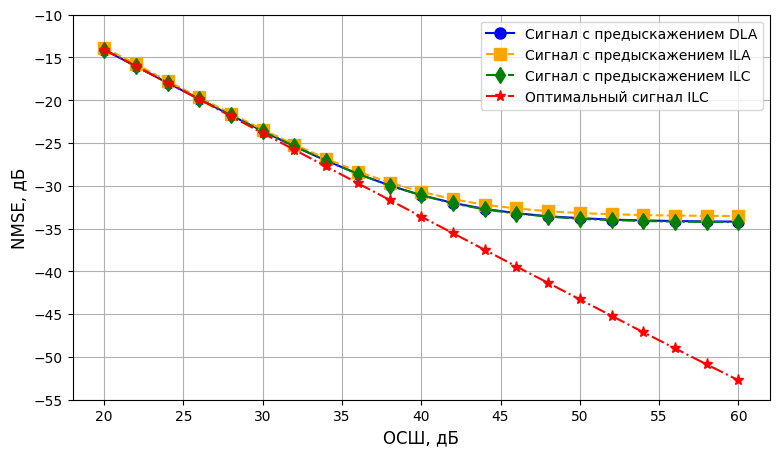

In [25]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
# plt.title("Зависимость NMSE от ОСШ")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


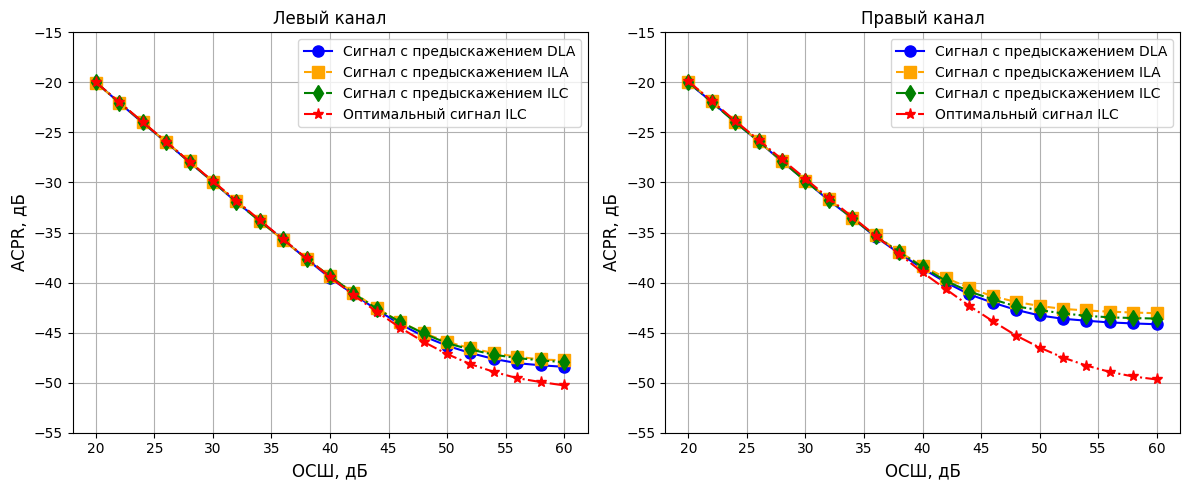

In [26]:
markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.plot(snr_range, acpr_left_dla_list, marker='o', color='blue', linestyle='-', label="Сигнал с предыскажением DLA")
# plt.plot(snr_range, acpr_left_ila_list, marker='s', color='orange', linestyle='--', label="Сигнал с предыскажением ILA")
# plt.plot(snr_range, acpr_left_ilc_list, marker='d', color='green', linestyle='-.', label="Сигнал с предыскажением ILC")
# plt.plot(snr_range, acpr_left_uk_list, marker='*', color='indigo', linestyle='-.', label="Оптимальный сигнал ILC")
plt.plot(snr_range, acpr_left_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_left_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_left_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_left_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, acpr_right_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_right_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_right_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_right_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
eng.quit()